# Verify noise level for 5 noise cases
- 10\%
- 20\%
- STD from data
- avg STD from data
- avg over time from data

In [1]:
# imports
import numpy as np
import cuqi
import sys
import matplotlib.pyplot as plt
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.geometry import Continuous2D
from cuqi.pde import TimeDependentLinearPDE
from cuqi.model import PDEModel
from advection_diffusion_inference_utils import parse_commandline_args,\
    read_data_files,\
    create_domain_geometry,\
    create_PDE_form,\
    create_prior_distribution,\
    create_exact_solution_and_data,\
    set_the_noise_std,\
    sample_the_posterior,\
    create_experiment_tag,\
    plot_experiment,\
    save_experiment_data,\
    Args,\
    build_grids,\
    create_time_steps,\
    plot_time_series

dill version:  0.3.9


#### Set up run arguments

In [2]:
args = Args()
noise_level_list= ["fromDataVar" , "fromDataAvg", "avgOverTime", 0.1, 0.2]
args.noise_level = noise_level_list[3]
args.animal = 'm1'
args.ear = 'l'
args.num_ST =0
args.inference_type = 'heterogeneous'
args.unknown_par_type = 'sampleMean'
args.unknown_par_value = ['m1:l:NUTS:constant:100.0:real:heterogeneous:1000:0.1:v:April22:2024:a::4:5@../../../Collab-BrainEfflux-Data/April_2x_2024_b']

tag = create_experiment_tag(args)
print(tag)



m1_l_MH_sampleMean_m1:l:NUTS:constant:100.0:real:heterogeneous:1000:0.1:v:April22:2024:a::4:5_syntheticFromDiffusion_heterogeneous_20_0.1_v_temp__0_5_none_zero


### Read the data

In [3]:
times, locations, real_data, real_std_data, diff_locations, real_data_diff, real_std_data_diff = read_data_files(args)
# The left boundary condition is given by the data  
real_bc = real_data.reshape([len(locations), len(times)])[0,:]

CA data.


### Create the forward model

In [4]:
#%% STEP 4: Create the PDE grid and coefficients grid
#----------------------------------------------------
# PDE and coefficients grids
L = locations[-1]*1.3
coarsening_factor = 5
n_grid_c = 20
grid, grid_c, grid_c_fine, h, n_grid = build_grids(L, coarsening_factor, n_grid_c)

#%% STEP 5: Create the PDE time steps array
#------------------------------------------
tau_max = 30*60 # Final time in sec
cfl = 5 # The cfl condition to have a stable solution
         # the method is implicit, we can choose relatively large time steps 
tau = create_time_steps(h, cfl, tau_max, adaptive=True)

#%% STEP 6: Create the domain geometry
#-------------------------------------
G_c = create_domain_geometry(grid_c, args.inference_type)

# STEP 7: Create the PDE form
#----------------------------
PDE_form = create_PDE_form(real_bc, None, grid, grid_c, grid_c_fine, n_grid, h, times,
                           args.inference_type)

# STEP 8: Create the CUQIpy PDE object
#-------------------------------------
PDE = TimeDependentLinearPDE(PDE_form,
                             tau,
                             grid_sol=grid,
                             method='backward_euler', 
                             grid_obs=locations,
                             time_obs=times) 

# STEP 9: Create the range geometry
#----------------------------------
G_cont2D = Continuous2D((locations, times))

# STEP 10: Create the CUQIpy PDE model
#-------------------------------------
A = PDEModel(PDE, range_geometry=G_cont2D, domain_geometry=G_c)

#### Create the prior distribution

Warning (GMRF): Periodic and Neumann boundary conditions are experimental. Sampling using LinearRTO may not produce fully accurate results.


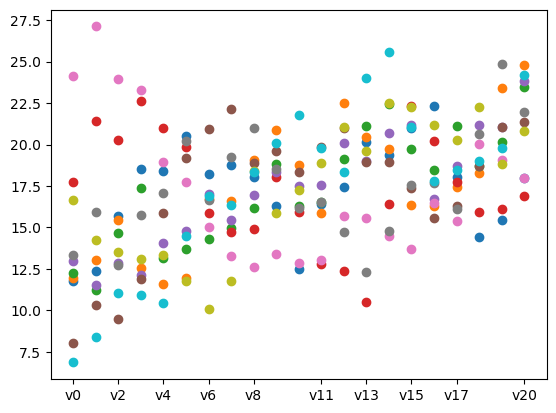

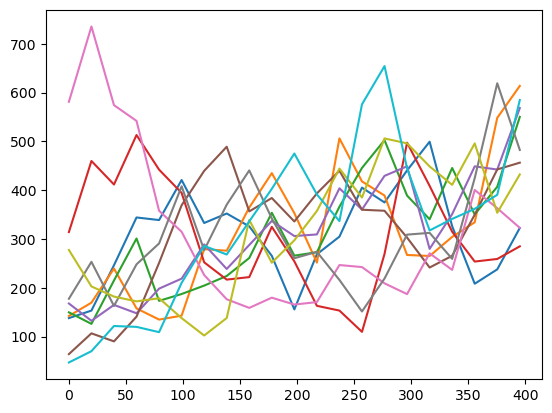

In [5]:
# STEP 11: Create the prior distribution
#---------------------------------------
x = create_prior_distribution(G_c, args.inference_type)

#from cuqi.distribution import GMRF
#x = GMRF(np.ones(G_c.par_dim)*np.sqrt(300), 0.2, geometry=G_c, bc_type='neumann')

Ns = 10
samples_x = x.sample(Ns)
samples_x.plot(range(Ns), plot_par=True)
plt.figure()
samples_x.funvals.plot(range(Ns))


#### Create and plot exact data

Reading data from:  ['m1:l:NUTS:constant:100.0:real:heterogeneous:1000:0.1:v:April22:2024:a::4:5@../../../Collab-BrainEfflux-Data/April_2x_2024_b']
Reading file:  ../../../Collab-BrainEfflux-Data/April_2x_2024_b/outputm1_l_NUTS_constant_100.0_real_heterogeneous_1000_0.1_v_April22_2024_a__4_5/m1_l_NUTS_constant_100.0_real_heterogeneous_1000_0.1_v_April22_2024_a__4_5_var.pkl


([<matplotlib.lines.Line2D at 0x1902dbd00>,
 ['loc = 0.00', 'loc = 72.11', 'loc = 144.22', 'loc = 229.07', 'loc = 303.91'])

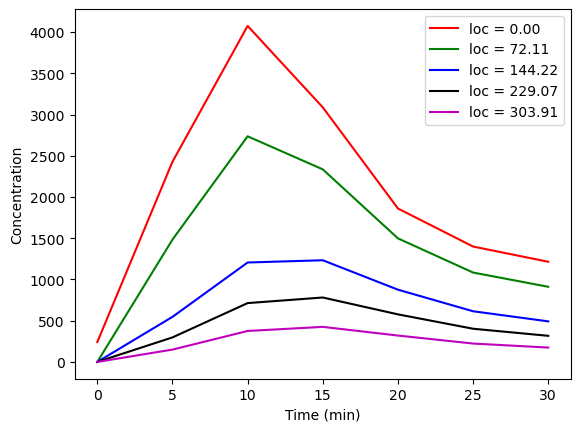

In [6]:
x_true, exact_data = create_exact_solution_and_data(A, args.unknown_par_type, args.unknown_par_value)
plot_time_series(times, locations, exact_data.reshape([len(locations), len(times)]))


#### Create the data distribution

Standard deviation values

**noise_level option**: fromDataVar
**STD of the noise**:
[280.764 436.623 761.026 750.994 281.877 344.629 381.76  437.303 527.705
 388.032 564.612 530.863 531.437 476.932 525.198 825.63  493.629 667.962
 597.311 613.488 627.32  609.606 705.079 468.724 377.973 540.082 400.862
 637.969 439.416 513.229 474.888 248.891 352.968 321.189 282.897]

**noise_level option**: fromDataAvg
**STD of the noise**:
497.6819428571428

**noise_level option**: avgOverTime
**STD of the noise**:
[462.52471429 462.52471429 462.52471429 462.52471429 462.52471429
 462.52471429 462.52471429 493.84057143 493.84057143 493.84057143
 493.84057143 493.84057143 493.84057143 493.84057143 621.50542857
 621.50542857 621.50542857 621.50542857 621.50542857 621.50542857
 621.50542857 534.32785714 534.32785714 534.32785714 534.32785714
 534.32785714 534.32785714 534.32785714 376.21114286 376.21114286
 376.21114286 376.21114286 376.21114286 376.21114286 376.21114286]

**noise_level option**: 0.1
**

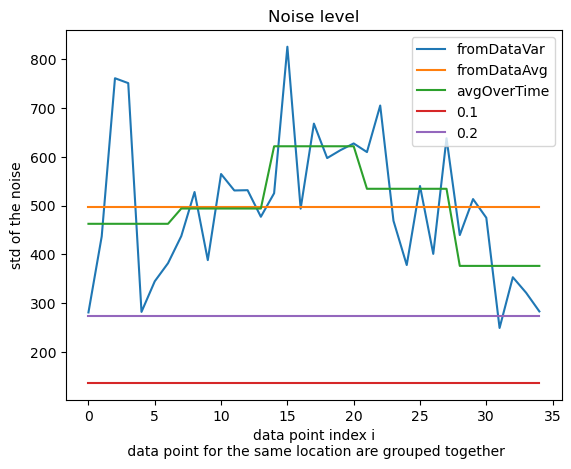

In [7]:
#%% STEP 13: Create the data distribution
#----------------------------------------
# First, illustrate how different noise levels setups affect the std
print("Standard deviation values")
plt.figure()
for item in noise_level_list:
    s_noise_temp = set_the_noise_std(
        args.data_type, item, exact_data,
        None, real_std_data, G_cont2D)
    print('\n**noise_level option**:', item)
    print('**STD of the noise**:')
    print(s_noise_temp)
    # plot noise level
    if isinstance(s_noise_temp, np.ndarray):
        plt.plot(s_noise_temp, label=str(item))
    else:
        plt.plot(s_noise_temp*np.ones(G_cont2D.par_dim), label=str(item))
plt.legend()
plt.title('Noise level')
plt.xlabel('data point index i\n data point for the same location are grouped together')
plt.ylabel('std of the noise')

# Second, set the noise level
s_noise = set_the_noise_std(args.data_type, args.noise_level, exact_data,
                                None, real_std_data, G_cont2D)
y = Gaussian(A(x), s_noise**2, geometry=G_cont2D)

#### Samples of noisy data and plot the noisy data and the noise

Noise to signal ratio (synthitic data):  0.09049805816501673
STD to signal ratio (real data):  0.2556061839993326


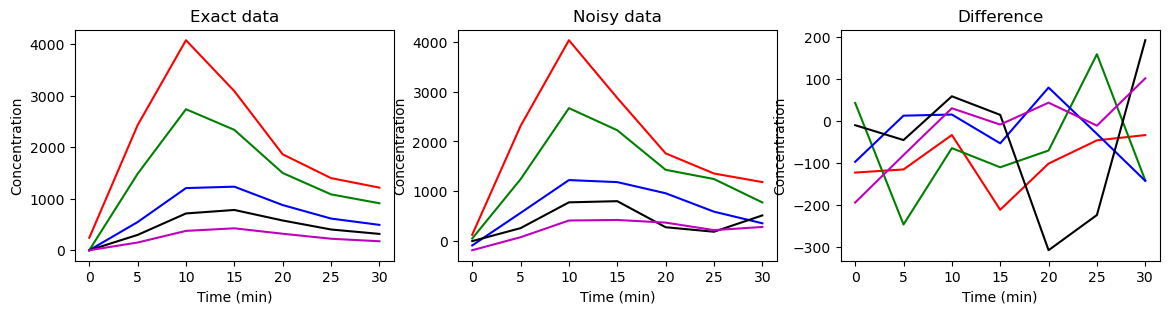

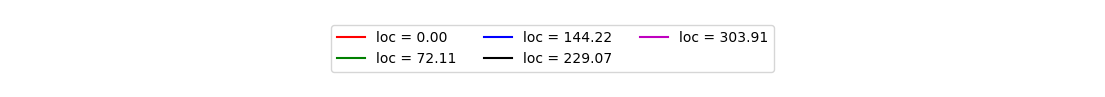

In [8]:
noisy_data = y(x=x_true).sample()

fig, ax = plt.subplots(1, 3, figsize=(14, 3))
plt.sca(ax[0])
plot_time_series(times, locations, exact_data.reshape([len(locations), len(times)]), plot_legend=False)
plt.title('Exact data')

plt.sca(ax[1])
plot_time_series(times, locations, noisy_data.reshape([len(locations), len(times)]), plot_legend=False)
plt.title('Noisy data')

diff = noisy_data - exact_data
plt.sca(ax[2])
lines, labels = plot_time_series(times, locations, diff.reshape([len(locations), len(times)]), plot_legend=False)
plt.title('Difference')
# Noise to signal ratio
print('Noise to signal ratio (synthitic data): ', np.linalg.norm(diff)/np.linalg.norm(noisy_data))
print('STD to signal ratio (real data): ', np.linalg.norm(real_std_data)/np.linalg.norm(real_data))

fig2 = plt.figure()
# turn off axis
plt.axis('off')
plt.legend(lines, labels, loc='center',ncol=3)
#figure size
fig2.set_size_inches(14, 1)



#### How subsampling the data affects the noise level

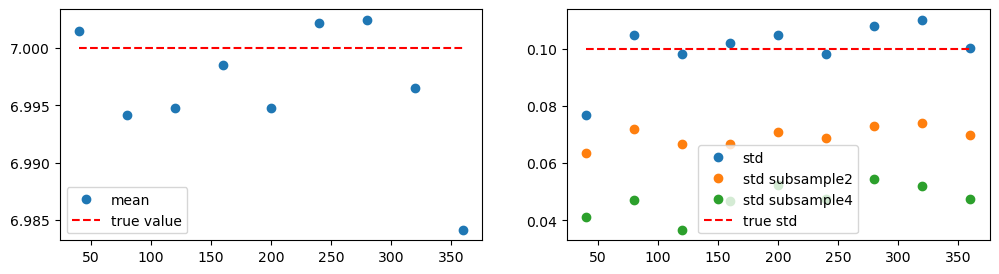

In [9]:
# assume we have n observations of the same value
# The values is 7
sl = [2, 4] # number of points to average in the subsample
means = []
stds = []

ns = [40*k for k in range(1,10)]
stds_sub = np.empty((len(sl), len(ns)))
for i, n in enumerate(ns):
  value = 7
  obs = value + np.random.randn(n)*0.1
  for j, n_subsample in enumerate(sl):
    # average the observations
    obs_sub = np.mean(obs.reshape(-1, n_subsample), axis=1)
    stds_sub[j, i] = np.std(obs_sub)

  means.append(np.mean(obs))
  stds.append(np.std(obs))

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
plt.sca(ax[0])
plt.plot(ns, means, 'o', label='mean')
plt.plot(ns,[value]*len(means), 'r--', label='true value')
plt.legend()
plt.sca(ax[1])
plt.plot(ns, stds, 'o', label='std')
for l in range(len(sl)):
  plt.plot(ns, stds_sub[l], 'o', label='std subsample'+str(sl[l]))
plt.plot(ns, [0.1]*len(stds), 'r--', label='true std')
plt.legend()

measurements: [7.02083261 6.828302   7.08012953 6.9173676  6.9230915  6.85751425
 6.95008136 6.83076458 7.06965116]
measurements mean: 6.94197051024424


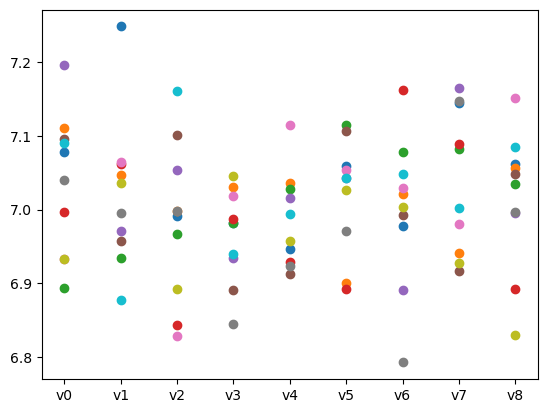

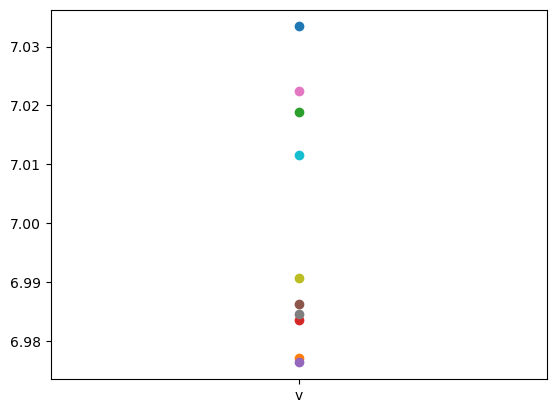

In [10]:
## A note on reducing the noise level by averaging

# Assume we have n measurements of the same value, true value is 7
true_value = 7
n = 9

# Assume the standard deviation of the measurement noise is 0.1
std = 0.1

# The measurements
measurement_noise = np.random.normal(size=n)*std
measurement = true_value + measurement_noise

# The measurements follow a Gaussian distribution
x_1 = Gaussian(true_value*np.ones(n), std**2)

# The mean of the measurements follows a Gaussian distribution, note
# the factor 1/sqrt(n) in the standard deviation
x_2 = Gaussian(true_value*np.ones(1), (std/np.sqrt(n))**2)

# Plot samples from the two distributions
plt.figure()
x_1.sample(10).plot(range(10), plot_par=True)
plt.figure()
x_2.sample(10).plot(range(10), plot_par=True)

# Print the measurements and the mean of the measurements
print('measurements:', measurement)
print('measurements mean:', np.mean(measurement))